# Emission quantification notebook

purpose: Calculating emissions rates using an inverse gaussian and mass balance approach and comparing the results in a boxplot.

author: Firmin Timo Stroo

email: f.t.stroo@rug.nl

organization: University of Groningen


# Inverse Gaussian

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import datetime as dt
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize
import itertools
import time
import copy
import random
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning) # Ignore deprecation warnings
conversion_factor =  1e9/((2.016*1e-3 )*(101325/(8.314*288.15))) # used to convert kg/m3 to ppb

def select_filter_process_observations(stacks, filename, percentile_lower, percentile_upper, percentile_avg):
    path = '/home/firmin.stroo/code/data/HYDRA/' # PATH TO DATE HERE
    files = os.listdir(path)
    obs = pd.read_csv(path + filename)

    # Filter data
    obs_raw = obs.copy()
    obs = obs[(obs['lat'] > 53.28) & (obs['lat'] < 53.35) & (obs['lon'] > 6.80) & (obs['lon'] < 7.05)] # filter for relevant area
    obs_rep = obs.groupby('H2').apply(lambda x: x.iloc[int(len(x)*(percentile_lower/100)):int(len(x)*(percentile_upper/100))]).sort_values('date').reset_index(drop=True) # select representative values
    obs_opt = obs.groupby('H2').apply(lambda x: x.iloc[int(len(x)*(percentile_avg/100))]).sort_values('date').reset_index(drop=True) # select optimum values
    
    return obs, obs_rep, obs_opt

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # radius of the Earth in meters
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = R * c # distance in meters between two points with coordinates (lat1, lon1) and (lat2, lon2)

    return d

def filter_close_to_stack(obs_rep, obs_opt, stacks):
    for i, stack in stacks.iterrows():
        for j, observation in obs_opt.iterrows():
            distance = haversine(stack['lat'], stack['lon'], observation['lat'], observation['lon'])
            if distance < 100:
                h2_value = observation['H2']
                obs_rep = obs_rep[obs_rep['H2'] != h2_value]
                obs_opt = obs_opt[obs_opt['H2'] != h2_value]
    
    return obs_rep, obs_opt

def filter_overlapping_observations(obs_rep, obs_opt, cutoff):
    unique_values = obs_opt['H2'].unique()
    overlapping = set()
    for value1, value2 in itertools.combinations(unique_values, 2):
        obs1 = obs_opt[obs_opt['H2'] == value1].iloc[0]
        obs2 = obs_opt[obs_opt['H2'] == value2].iloc[0]
        if haversine(obs1['lat'], obs1['lon'], obs2['lat'], obs2['lon']) < cutoff:
            overlapping.add(min(value1, value2))
    obs_rep = obs_rep[~obs_rep['H2'].isin(overlapping)]
    obs_opt = obs_opt[~obs_opt['H2'].isin(overlapping)]

    return obs_rep, obs_opt
    
def calculate_advection_term(obs, phi_wind, stacks, bg_percentile):
    is_upwind = pd.Series([True]*len(obs), index=obs.index)
    for _, stack in stacks.iterrows():
        obs_angles = ((np.degrees(np.arctan2(obs['lon'] - stack['lon'], obs['lat'] - stack['lat'])) + 180) - phi_wind) % 360 # Calculate angle between wind direction and observation (always between 0 and 360 degrees)
        is_upwind &= (obs_angles >= 90) & (obs_angles <= 270) # Check if observation is upwind of the stack
    h2_upwind = obs[is_upwind & obs['H2'].duplicated(keep=False)]['H2'].quantile(bg_percentile/100) # Calculate the background mole fraction based on the upwind obs
    
    return h2_upwind

def calculate_plume_coordinates(obs, stack, phi_wind):
    phi_wind = phi_wind % 360  # Ensure phi_wind is within 0-360
    time = obs['date'] if 'date' in obs.columns else np.nan # time is not always available
    h2_obs = obs['H2'] if 'H2' in obs.columns else np.nan # h2 is not always available
    
    obs_lat, obs_lon = obs['lat'], obs['lon'] # extract latitude and longitude from observations
    stack_lat, stack_lon = stack['lat'], stack['lon'] # extract latitude and longitude from stack
    obs_lat_rad, obs_lon_rad = np.radians(obs_lat), np.radians(obs_lon) # convert to radians
    stack_lat_rad, stack_lon_rad = np.radians(stack_lat), np.radians(stack_lon) # convert to radians

    R_Earth = 6371000  # Earth radius in meters
    delta_lat = obs_lat_rad - stack_lat_rad
    delta_lon = obs_lon_rad - stack_lon_rad
    dx = R_Earth * delta_lon * np.cos((obs_lat_rad + stack_lat_rad) / 2) # 
    dy = R_Earth * delta_lat # calculate y-plume coordinates

    phi_obs = np.degrees(np.arctan2(dx, dy)) + 180 # calculate the angle of the plume with respect to the north
    phi_tot = phi_obs - phi_wind # calculate the angle of the plume relative to the wind direction and the north
    L = (dx**2 + dy**2)**0.5 
    x_plume = L * np.cos(np.radians(phi_tot)) # calculate x-plume coordinates
    y_plume = L * np.sin(np.radians(phi_tot)) # calculate y-plume coordinates
    z_plume = obs['alt'] - stack['alt'] # calculate z-plume coordinates

    plume_coordinates = pd.DataFrame({ 
        'time': time, 
        'lat': obs_lat, 
        'lon': obs_lon, 
        'x_plume': x_plume, 
        'y_plume': y_plume, 
        'z_plume': z_plume, 
        'dx': dx, 
        'dy': dy, 
        'h2_obs': h2_obs, 
        'phi_obs': phi_obs,
        'alt': obs['alt']
    })

    return plume_coordinates

def gaussian_plume_model(emissions, windspeed, stacks, plume_coordinates, stability_parameters, sigma_multiplier):
    a, s, q, r, p = stability_parameters    # Extract stability parameters
    x_stack, y_stack, z_stack = np.zeros(len(stacks)), np.zeros(len(stacks)), np.zeros(len(stacks))  # Assume all stacks have position 0,0,0
    x_plume, y_plume, z_plume = np.array(plume_coordinates['x_plume']), np.array(plume_coordinates['y_plume']), np.array(plume_coordinates['z_plume']) # Extract plume coordinates from DataFrame and convert to numpy array
    
    c_sample = []  # Initialize sample concentration array
    for (x, y, z) in zip(x_plume, y_plume, z_plume):
        ctot = 0.0  # Initialize total concentration [kg/m3]
        for (e, xs, ys, zs) in zip(emissions, x_stack, y_stack, z_stack):  # Loop over all stacks
            if x > xs: # Ensure plume calculation only occurs if x > xs to avoid undefined behavior
                # sigmay, sigmaz = Fd*(x-xs)**fd, Gd*(x-xs)**gd  # Calculate dispersion parameters
                sigmay = (r*(x-xs)) / (1+((x-xs)/a))**p
                sigmaz = (s*(x-xs)) / (1+((x-xs)/a))**q

                if abs(y-ys) < sigma_multiplier*sigmay and abs(z-zs) < sigma_multiplier*sigmaz: # 2 sigma rule
                    c_plume = (e / windspeed) * (1. / (2 * np.pi * sigmay * sigmaz)) * np.exp(-((y-ys)**2) / (2 * sigmay**2)) * (np.exp(-((z-zs)**2) / (2 * sigmaz**2)) + np.exp(-((z+zs)**2) / (2 * sigmaz**2))) # Updated GPM including ground reflection term
                else:
                    c_plume = np.nan
            else:
                c_plume = np.nan
            ctot += c_plume  # Add plume concentration to total concentration
        c_sample.append(ctot)

    return np.array(c_sample)

def apply_rug_sampling(obs, gpm, obs_opt):
    unique_sample_means = pd.merge(obs, gpm, left_on='H2', right_on='h2_obs').groupby('H2')['h2_gpm_total'].apply(lambda x: np.nanmean(x.tolist())) # Group by H2 and calculate mean
    obs_rug = obs_opt[['H2', 'lat', 'lon', 'alt', 'Jackknifed']].drop_duplicates().set_index('H2') # Drop duplicates
    obs_rug['h2_gpm_total'] = unique_sample_means # Add sample means to DataFrame
    obs_rug = obs_rug.reset_index()

    return obs_rug

def calculate_combined_plumes_using_short_state_vector(state_vector, observations, stacks, windspeed, phi_wind, conversion_factor, stability_parameters, sigma_multiplier):
    emissions = state_vector  # State vector are emissions
    stacks['alt'] = stacks['alt'] # Use original stack heights

    total_plume_df = pd.DataFrame() # Initialize DataFrame to store total plume concentrations
    for i in range(len(stacks)): 
        stack_name = stacks['location'][i]
        stack = stacks[stacks['location'] == stack_name].iloc[0]
        plume_df = calculate_plume_coordinates(observations, stack, phi_wind)
        plume_df['plume_concentration'] = gaussian_plume_model(emissions, windspeed, stacks, plume_df, stability_parameters, sigma_multiplier).flatten() # Calculate plume concentrations
        if total_plume_df.empty:
            total_plume_df = plume_df.copy()
            total_plume_df['h2_gpm_total'] = plume_df['plume_concentration']
            total_plume_df[stack_name] = plume_df['plume_concentration']
        else:
            total_plume_df['h2_gpm_total'] = total_plume_df['h2_gpm_total'].add(plume_df['plume_concentration'], fill_value=0)
            total_plume_df[stack_name] = total_plume_df[stack_name].add(plume_df['plume_concentration'], fill_value=0) if stack_name in total_plume_df else plume_df['plume_concentration']
    total_plume_df['h2_gpm_total'] *= conversion_factor
    for stack_name in stacks['location']:
        total_plume_df[stack_name] *= conversion_factor
    total_plume_df = total_plume_df.drop(columns=['plume_concentration', 'x_plume', 'y_plume', 'z_plume', 'dx', 'dy'])

    return total_plume_df

def objective_function(state_vector, observations, stacks, windspeed, phi_wind, conversion_factor, stability_parameters, sigma_multiplier, error_minimum, error_obs):
    h2_gpm = calculate_combined_plumes_using_short_state_vector(state_vector, observations, stacks, windspeed, phi_wind, conversion_factor, stability_parameters, sigma_multiplier)['h2_gpm_total']
    h2_obs = observations['H2_enhancement']
    total_error = error_minimum + (h2_obs * error_obs) # total error value based on the minimum error and the error of the observations
    total_error[observations['Jackknifed']] = 1e9 # For jackknifed observations, the total error is set to 1e9 to ensure that the jackknifed observations are not included in the optimization
    difference = np.sum((h2_gpm - h2_obs)**2 / total_error**2) # sum of squared difference between model and observations scaled by the total error

    return difference

def jackknife_obs(obs_rep, obs_opt, jackknifed_fraction):
    obs_rep_jackknife, obs_opt_jackknife = obs_rep.copy(), obs_opt.copy()
    # Assign a boolean value to each observation that is True if the observation is part of the jackknifed fraction (e.g. if jackknifed_fraction = 0.25, 25% of the observations will be jackknifed)
    if len(obs_opt_jackknife) >= 3: # Only jackknife if there are at least 3 observations. Round of to nearest integer. 
        obs_opt_jackknife['Jackknifed'] = obs_opt_jackknife['H2'].isin(random.sample(list(obs_opt_jackknife['H2']), int(len(obs_opt_jackknife)*jackknifed_fraction)))
    # For H_2 values in obs_opt that are jackknifed, also give the corresponding values in obs_rep the same value for Jackknifed
    obs_rep_jackknife['Jackknifed'] = obs_rep_jackknife['H2'].isin(obs_opt_jackknife[obs_opt_jackknife['Jackknifed']]['H2'])

    return obs_rep_jackknife, obs_opt_jackknife

def automated_optimization(selected_run):
    start_time = time.time()
    optimization_summary = {}
    filename, windspeed, phi_wind, stacks, percentile_lower, percentile_upper, percentile_avg, stability_parameters, bg_percentile, sigma_multiplier, windspeed_uncertainty, error_minimum, error_obs = selected_run.values()
    optimization_summary['windspeed'], optimization_summary['phi_wind'], optimization_summary['stacks'], optimization_summary['stability_parameters'], optimization_summary['error_minimum'], optimization_summary['error_obs'] = windspeed, phi_wind, stacks, stability_parameters, error_minimum, error_obs

    obs, obs_rep, obs_opt = select_filter_process_observations(stacks, filename, percentile_lower, percentile_upper, percentile_avg)

    filtering = False
    if filtering:
        obs_rep, obs_opt = filter_close_to_stack(obs_rep, obs_opt, stacks) # Remove observations close to stack
        if 'car' in filename: # Remove overlapping observations
            obs_rep, obs_opt = filter_overlapping_observations(obs_rep, obs_opt, cutoff=10) 

    # Calculate upwind value
    if 'car' in filename:
        h2_upwind = calculate_advection_term(obs_rep, phi_wind, stacks, bg_percentile)
        # if h2_upwind is nan, take 10th percentile as upwind value
        if np.isnan(h2_upwind):
            h2_upwind = obs_rep['H2'].quantile(0.1)
    elif 'drone' in filename: # take 10th percentile as upwind value
        h2_upwind = obs_rep['H2'].quantile(0.1)
    obs_rep['H2_enhancement'] = obs_rep['H2'] - h2_upwind 
    obs_opt['H2_enhancement'] = obs_opt['H2'] - h2_upwind
    # Apply jackknifing
    obs_rep, obs_opt = jackknife_obs(obs_rep, obs_opt, jackknifed_fraction=0.20)

    x0 = stacks['emissions'].values  # Initial guess for the state vector
    emissions_bounds = [(0, None) for _ in range(len(stacks))]  # Set emission bounds
    bounds = emissions_bounds  # Set bounds for state vector

    result = minimize(objective_function, x0, args=(obs_rep, stacks, windspeed, phi_wind, conversion_factor, stability_parameters, sigma_multiplier, error_minimum, error_obs), bounds=bounds) # Optimize
    execution_time = time.time() - start_time

    if result.success:
        xopt = result.x
        # Generate statistics
        gpm_opt = calculate_combined_plumes_using_short_state_vector(xopt, obs_rep, stacks, selected_run['windspeed'], selected_run['phi_wind'], conversion_factor, selected_run['stability_parameters'], selected_run['sigma_multiplier'])
        obs_suitable = obs_rep[~np.isnan(gpm_opt['h2_gpm_total'])]
        gpm_opt_rug = apply_rug_sampling(obs_suitable, gpm_opt, obs_opt)
        df = pd.DataFrame({'x': gpm_opt_rug['H2'] - h2_upwind, 'y': gpm_opt_rug['h2_gpm_total'], 'Jackknifed': gpm_opt_rug['Jackknifed']}).dropna()      
        x, y = df['x'], df['y']
        x_filtered, y_filtered = df['x'][~df['Jackknifed']], df['y'][~df['Jackknifed']]
        optimization_summary['F1_Sufficient_data'] = True if len(x_filtered) >= 2 else False

        if optimization_summary['F1_Sufficient_data'] == True:
            # Boolean indicating if Total emissions is not null
            optimization_summary['F2_Optimization_not_null'] = True if xopt.sum() > 0 else False
            optimization_summary['F3_Slope_positive'] = True if linregress(x, y).slope > 0 else False
            optimization_summary['F4_Optimization_successful'] = True if optimization_summary['F1_Sufficient_data'] and optimization_summary['F2_Optimization_not_null'] and optimization_summary['F3_Slope_positive'] else False
            # optimization_summary['Filename'] = filename
            optimization_summary['Runtime'] = execution_time
            optimization_summary['N_optimized'] = len(x)
            # Add values of the obervations that are used in the optimization
            optimization_summary['Obs_used'] = x_filtered
            # also add fun, jac, hess from result in scipy.optimize.minimize
            optimization_summary['Fun'] = result.fun
            optimization_summary['Jac'] = result.jac
            # Save emissions per stack to dictionary
            for i, stack in stacks.iterrows():
                optimization_summary[stack['location']] = xopt[i]*24*3600 # add emissions per stack to the dictionary
            optimization_summary['Total emissions'] = xopt.sum()*24*3600 # add the total emissions to the dictionary
            optimization_summary['Slope'] = linregress(x, y).slope
            optimization_summary['R_squared'] = linregress(x, y).rvalue**2
            optimization_summary['RMSE_all_obs'] = np.sqrt(np.mean((x - y)**2))
            optimization_summary['RMSE_filtered'] = np.sqrt(np.mean((x_filtered - y_filtered)**2))

            return xopt, optimization_summary, obs_rep, obs_opt, h2_upwind
        else:

            return None, None, None, None, None

    else:
        print("Optimization failed:", result.message)
        
        return None, None, None, None, None

def create_experiment_parameters(baserun_parameters, phi_wind_range):
    experiment = copy.deepcopy(baserun_parameters)
    experiment['windspeed'] = baserun_parameters['windspeed'] + np.random.uniform(0, baserun_parameters['windspeed_uncertainty'])
    experiment['phi_wind'] = baserun_parameters['phi_wind'] + np.random.uniform(-phi_wind_range, phi_wind_range)
    experiment['stacks']['alt'] = np.where(experiment['stacks']['location'].isin(['Stack2', 'Stack4', 'Stack1']), np.random.uniform(5, 20), np.random.uniform(50, 100))
    experiment['stability_parameters'] = random.choice([[707, 0.0472, 0.465, 0.079, 0.135], [283, 0.0722, 0.102, 0.134, 0.134]])  # Options for stability parameters
    experiment['error_minimum'] = np.random.uniform(5, 25)
    experiment['error_obs'] = np.random.uniform(0.01, 0.05)
    
    return experiment

def run_single_experiment(experiment):
    optimized_state_vector, optimization_summary, obs_rep, obs_opt, h2_upwind = automated_optimization(experiment)
    optimization_summary = optimization_summary or {}

    return optimization_summary

def run_monte_carlo(all_baseruns, phi_wind_range, n_successful):
    all_results = {}
    start = time.time()

    for baserun in all_baseruns:
        filename = baserun['filename']
        print(f"Running monte carlo for {baserun['filename']}")
        successful_count = 0
        experiments_results = []
        experiment_id = 0  # Initialize experiment counter

        # Run baserun
        result = run_single_experiment(baserun)
        result['experiment_id'] = 'baserun'  # Indicate that this is a base run
        experiments_results.append(result)
        if result.get('F4_Optimization_successful', False):
            successful_count += 1

        # Run monte carlo
        while successful_count < n_successful:
            experiment = create_experiment_parameters(baserun, phi_wind_range)
            result = run_single_experiment(experiment)
            experiment_id += 1  # Increment experiment counter
            result['experiment_id'] = f'experiment_{experiment_id}'  # Add experiment_id to the result
            experiments_results.append(result)
            if result.get('F4_Optimization_successful', False):
                successful_count += 1

        all_results[baserun['filename']] = pd.DataFrame(experiments_results)
        all_results[baserun['filename']] = all_results[baserun['filename']].set_index(['experiment_id']).reset_index()

    duration = time.time() - start
    print(f'Completed Monte Carlo optimization. Runtime: {duration:.2f} seconds.')

    all_results = pd.concat(all_results.values(), keys=all_results.keys(), names=['measurement_id']).reset_index(level=0) # Add measurement_id as index

    return all_results
    
#_______________________________________________________________________________________________________________________
# Running
#_______________________________________________________________________________________________________________________

stacks = pd.DataFrame({
    'location': ['Stack1', 'Stack2', 'Stack3', 'Stack4', 'Stack5'],
    'lon': [6.945167, 6.967346, 6.986969, 6.952158, 6.954452],
    'lat': [53.319026, 53.311585, 53.309487, 53.317080, 53.318732],
    'alt': [10, 10, 45, 5, 70],
    'emissions': [50/(24*3600), 50/(24*3600), 1/(24*3600), 1/(24*3600), 1/(24*3600)]}) # emissions in kg/s
    
baserun_parameters= {           
    'filename': 'a.csv',
    'windspeed': 0,
    'phi_wind': 0,
    'stacks': stacks,
    'percentile_lower': 73,
    'percentile_upper': 93,
    'percentile_avg': 83,
    'stability_parameters': [707, 0.0472, 0.465, 0.079, 0.135], # neutral conditions
    'bg_percentile': 10.0,
    'sigma_multiplier': 3.0,
    'windspeed_uncertainty': 1.0,
    'error_minimum': 10,
    'error_obs': 0.05
}

baserun_parameters_car_2023_08_04 = {**baserun_parameters, 'filename': 'car_2023_08_04.csv', 'windspeed' : 6.6, 'phi_wind': 306, 'windspeed_uncertainty': 1.0}
baserun_parameters_car_2023_09_06 = {**baserun_parameters, 'filename': 'car_2023_09_06.csv', 'windspeed' : 4.5, 'phi_wind': 144, 'windspeed_uncertainty': 1.4}
baserun_parameters_car_2023_09_11 = {**baserun_parameters, 'filename': 'car_2023_09_11.csv', 'windspeed' : 6.4, 'phi_wind': 290, 'windspeed_uncertainty': 1.5}
baserun_parameters_car_2023_10_12 = {**baserun_parameters, 'filename': 'car_2023_10_12.csv', 'windspeed' : 1.8, 'phi_wind': 290, 'windspeed_uncertainty': 0.8}
baserun_parameters_car_2023_12_06 = {**baserun_parameters, 'filename': 'car_2023_12_06.csv', 'windspeed' : 4.0, 'phi_wind': 292, 'windspeed_uncertainty': 1.5}

baserun_parameters_drone_2023_10_05 = {**baserun_parameters, 'filename': 'drone_2023_10_05.csv', 'windspeed' : 5.8, 'phi_wind': 295, 'windspeed_uncertainty': 1}
baserun_parameters_drone_2023_10_12 = {**baserun_parameters, 'filename': 'drone_2023_10_12.csv', 'windspeed' : 1.8, 'phi_wind': 293, 'windspeed_uncertainty': 0.8}
baserun_parameters_drone_2023_12_06 = {**baserun_parameters, 'filename': 'drone_2023_12_06.csv', 'windspeed' : 4.0, 'phi_wind': 313, 'windspeed_uncertainty': 1.5}

all_baseruns = [baserun_parameters_car_2023_08_04, baserun_parameters_car_2023_09_06, baserun_parameters_car_2023_09_11, baserun_parameters_car_2023_10_12, baserun_parameters_car_2023_12_06, baserun_parameters_drone_2023_10_05, baserun_parameters_drone_2023_10_12, baserun_parameters_drone_2023_12_06]

n_successful = 500 # Set desired number of successful optimizations
phi_wind_range = 30 # Set range for phi_wind
full_output = run_monte_carlo(all_baseruns, phi_wind_range, n_successful)

save_results_monte_carlo = True
if save_results_monte_carlo:
    results_path = '/home/firmin.stroo/code/aether_python/output/' # SAVE OUTPUT HERE
    full_output.to_csv(results_path + 'a5_nofilter_n500.csv', index=False)

# Mass balance

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import itertools
import time
import copy
import random
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning) # Ignore deprecation warnings
conversion_factor =  1e9/((2.016*1e-3 )*(101325/(8.314*288.15))) # used to convert kg/m3 to ppb

def select_filter_process_observations(stacks, filename, percentile_lower, percentile_upper, percentile_avg):
    path = '/home/firmin.stroo/code/data/HYDRA/' # PATH TO DATA HERE
    files = os.listdir(path)
    obs = pd.read_csv(path + filename)

    # Filter data
    obs_raw = obs.copy()
    obs = obs[(obs['lat'] > 53.28) & (obs['lat'] < 53.35) & (obs['lon'] > 6.80) & (obs['lon'] < 7.05)] # filter for relevant area
    obs_rep = obs.groupby('H2').apply(lambda x: x.iloc[int(len(x)*(percentile_lower/100)):int(len(x)*(percentile_upper/100))]).sort_values('date').reset_index(drop=True) # select representative values
    obs_opt = obs.groupby('H2').apply(lambda x: x.iloc[int(len(x)*(percentile_avg/100))]).sort_values('date').reset_index(drop=True) # select optimum values
    
    return obs, obs_rep, obs_opt

def additional_filtering(filename, obs, obs_representative, obs_optimum):
    # Filter 1: Remove values above x ppb
    x = 990
    obs, obs_representative, obs_optimum = obs[obs['H2'] < x], obs_representative[obs_representative['H2'] < x], obs_optimum[obs_optimum['H2'] < x]

    # Filter 2: Remove values outside of park domain by time stamp
    # for 08_04: remove values after 11:45
    if '08_04' in filename:
        obs, obs_representative, obs_optimum = obs[obs['date'] < '2023-08-04 11:45:00'], obs_representative[obs_representative['date'] < '2023-08-04 11:45:00'], obs_optimum[obs_optimum['date'] < '2023-08-04 11:45:00']
    # for 09_06: remove values before 13:03 and after 14:27
    if '09_06' in filename:
        obs, obs_representative, obs_optimum = obs[obs['date'] > '2023-09-06 13:03:00'], obs_representative[obs_representative['date'] > '2023-09-06 13:03:00'], obs_optimum[obs_optimum['date'] > '2023-09-06 13:03:00']
    # for 09_11: remove values before 14:30:30 and after 15:37:49
    if '09_11' in filename:
        obs, obs_representative, obs_optimum = obs[obs['date'] > '2023-09-11 14:30:30'], obs_representative[obs_representative['date'] > '2023-09-11 14:30:30'], obs_optimum[obs_optimum['date'] > '2023-09-11 14:30:30']
    # for 10_12: no additional filtering needed
    if '10_12' in filename:
        pass
    # for 06_12: no additional filtering needed
    if '06_12' in filename:
        pass

    return obs, obs_representative, obs_optimum

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # radius of the Earth in meters
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = R * c # distance in meters between two points with coordinates (lat1, lon1) and (lat2, lon2)

    return d

def filter_close_to_stack(obs_rep, obs_opt, stacks):
    for i, stack in stacks.iterrows():
        for j, observation in obs_opt.iterrows():
            distance = haversine(stack['lat'], stack['lon'], observation['lat'], observation['lon'])
            if distance < 100:
                h2_value = observation['H2']
                obs_rep = obs_rep[obs_rep['H2'] != h2_value]
                obs_opt = obs_opt[obs_opt['H2'] != h2_value]
    
    return obs_rep, obs_opt

def filter_overlapping_observations(obs_rep, obs_opt, cutoff):
    unique_values = obs_opt['H2'].unique()
    overlapping = set()
    for value1, value2 in itertools.combinations(unique_values, 2):
        obs1 = obs_opt[obs_opt['H2'] == value1].iloc[0]
        obs2 = obs_opt[obs_opt['H2'] == value2].iloc[0]
        if haversine(obs1['lat'], obs1['lon'], obs2['lat'], obs2['lon']) < cutoff:
            overlapping.add(min(value1, value2))
    obs_rep = obs_rep[~obs_rep['H2'].isin(overlapping)]
    obs_opt = obs_opt[~obs_opt['H2'].isin(overlapping)]

    return obs_rep, obs_opt
    
def calculate_advection_term(obs, phi_wind, stacks, bg_percentile):
    is_upwind = pd.Series([True]*len(obs), index=obs.index)
    for _, stack in stacks.iterrows():
        obs_angles = ((np.degrees(np.arctan2(obs['lon'] - stack['lon'], obs['lat'] - stack['lat'])) + 180) - phi_wind) % 360 # Calculate angle between wind direction and observation (always between 0 and 360 degrees)
        is_upwind &= (obs_angles >= 90) & (obs_angles <= 270) # Check if observation is upwind of the stack
    h2_upwind = obs[is_upwind & obs['H2'].duplicated(keep=False)]['H2'].quantile(bg_percentile/100) # Calculate the background mole fraction based on the upwind obs
    
    return h2_upwind

def mass_balance(windspeed, phi_wind_perturbation, crosssection_area, molefraction_h2):
    u = windspeed # wind speed in m/s
    theta = np.radians(np.abs(phi_wind_perturbation))
    M_H2 = 2.01588*1e-3 # molecular weight of H2 in kg/mol
    R = 8.314 # universal gas constant in J/(mol*K)
    T = 288.15 # temperature in K
    P = 101325 # atmospheric pressure in Pa
    Q_kg_s = molefraction_h2/1e9*P*M_H2/(R*T)*u*np.cos(theta)*crosssection_area # mass flow rate in kg/s
    Q_kg_day = Q_kg_s*3600*24 
  
    return Q_kg_day

#_______________________________________________________________________________________________________________________
# Running
#_______________________________________________________________________________________________________________________

stacks = pd.DataFrame({
    'location': ['Stack1', 'Stack2', 'Stack3', 'Stack4', 'Stack5'],
    'lon': [6.945167, 6.967346, 6.986969, 6.952158, 6.954452],
    'lat': [53.319026, 53.311585, 53.309487, 53.317080, 53.318732],
    'alt': [10, 10, 45, 5, 70],
    'emissions': [50/(24*3600), 50/(24*3600), 1/(24*3600), 1/(24*3600), 1/(24*3600)]}) # emissions in kg/s
    
baserun_parameters= {
    'filename': 'a.csv',   
    'windspeed': 0,
    'phi_wind': 0,
    'phi_wind_perturbation': 0,
    'stacks': stacks,
    'percentile_lower': 73,
    'percentile_upper': 93,
    'percentile_avg': 83,
    'bg_percentile': 10.0,
    'windspeed_uncertainty': 1.0,
    'mixing_layer_height': 0,
    'crosssection_area': 150*1000}

baserun_parameters_car_2023_08_04 = {**baserun_parameters, 'filename': 'car_2023_08_04.csv', 'windspeed' : 6.6, 'phi_wind': 306, 'windspeed_uncertainty': 1.0, 'mixing_layer_height': 90}
baserun_parameters_car_2023_09_06 = {**baserun_parameters, 'filename': 'car_2023_09_06.csv', 'windspeed' : 4.5, 'phi_wind': 144, 'windspeed_uncertainty': 1.4, 'mixing_layer_height': 200}
baserun_parameters_car_2023_09_11 = {**baserun_parameters, 'filename': 'car_2023_09_11.csv', 'windspeed' : 6.4, 'phi_wind': 290, 'windspeed_uncertainty': 1.5, 'mixing_layer_height': 110}
baserun_parameters_car_2023_10_12 = {**baserun_parameters, 'filename': 'car_2023_10_12.csv', 'windspeed' : 1.8, 'phi_wind': 290, 'windspeed_uncertainty': 0.8, 'mixing_layer_height': 150}
baserun_parameters_car_2023_12_06 = {**baserun_parameters, 'filename': 'car_2023_12_06.csv', 'windspeed' : 4.0, 'phi_wind': 292, 'windspeed_uncertainty': 1.5, 'mixing_layer_height': 90}

baserun_parameters_drone_2023_10_05 = {**baserun_parameters, 'filename': 'drone_2023_10_05.csv', 'windspeed' : 5.8, 'phi_wind': 295, 'windspeed_uncertainty': 1, 'mixing_layer_height': 120}
baserun_parameters_drone_2023_10_12 = {**baserun_parameters, 'filename': 'drone_2023_10_12.csv', 'windspeed' : 1.8, 'phi_wind': 293, 'windspeed_uncertainty': 0.8, 'mixing_layer_height': 150}
baserun_parameters_drone_2023_12_06 = {**baserun_parameters, 'filename': 'drone_2023_12_06.csv', 'windspeed' : 4.0, 'phi_wind': 313, 'windspeed_uncertainty': 1.5, 'mixing_layer_height': 90}

all_baseruns = [baserun_parameters_car_2023_08_04, baserun_parameters_car_2023_09_06, baserun_parameters_car_2023_09_11, baserun_parameters_car_2023_10_12, baserun_parameters_car_2023_12_06, baserun_parameters_drone_2023_10_05, baserun_parameters_drone_2023_10_12, baserun_parameters_drone_2023_12_06]

def create_experiment_parameters(baserun_parameters, phi_wind_range):
    experiment = copy.deepcopy(baserun_parameters)
    experiment['windspeed'] = baserun_parameters['windspeed'] + np.random.uniform(0, baserun_parameters['windspeed_uncertainty'])
    phi_wind_perturbation = np.random.uniform(-phi_wind_range, phi_wind_range)
    experiment['phi_wind_perturbation'] = phi_wind_perturbation
    experiment['phi_wind'] = baserun_parameters['phi_wind'] + phi_wind_perturbation
    experiment['stacks']['alt'] = np.where(experiment['stacks']['location'].isin(['Stack2', 'Stack4', 'Stack1']), np.random.uniform(5, 20), np.random.uniform(50, 100))
    dx = np.random.uniform(750, 1250) # Assumption Iris
    H = experiment['mixing_layer_height'] + np.random.uniform(-0.2*experiment['mixing_layer_height'], 0.2*experiment['mixing_layer_height']) # Assumption Iris
    experiment['crosssection_area'] = dx*H

    return experiment

def run_monte_carlo(all_baseruns, phi_wind_range, n):
    all_output = []

    for baserun in all_baseruns:
        print(f'Running Monte Carlo Mass Balance for: {baserun["filename"]}')
        obs_id = 0 # initialize observation id
        # extract baserun parameters
        filename, windspeed, phi_wind, phi_wind_perturbation, stacks, percentile_lower, percentile_upper, percentile_avg, bg_percentile, windspeed_uncertainty, mixing_layer_height, crosssection_area = baserun.values()
        # select, filter and process observations
        obs, obs_rep, obs_opt = select_filter_process_observations(stacks, filename, percentile_lower, percentile_upper, percentile_avg)
        # additional filtering
        obs, obs_rep, obs_opt = additional_filtering(filename, obs, obs_rep, obs_opt)
        
        # Filter observations
        obs_rep, obs_opt = filter_close_to_stack(obs_rep, obs_opt, stacks) # Remove observations close to stack
        if 'car' in filename: # Remove overlapping observations
            obs_rep, obs_opt = filter_overlapping_observations(obs_rep, obs_opt, cutoff=10) 
        # Calculate upwind value
        if 'car' in filename:
            h2_upwind = calculate_advection_term(obs_rep, phi_wind, stacks, bg_percentile)
            # if h2_upwind is nan, take 10th percentile as upwind value
            if np.isnan(h2_upwind):
                h2_upwind = obs_rep['H2'].quantile(0.1)
        elif 'drone' in filename: # take 10th percentile as upwind value
            h2_upwind = obs_rep['H2'].quantile(0.1)
        obs_rep['H2_enhancement'] = obs_rep['H2'] - h2_upwind 
        obs_opt['H2_enhancement'] = obs_opt['H2'] - h2_upwind

        # to list, converto to kg/m3 and remove negative values
        H2_enhancement_obs = obs_opt['H2_enhancement'].values.tolist()
        # H2_enhancement_obs = [i/conversion_factor for i in H2_enhancement_obs]
        H2_enhancement_obs = [i for i in H2_enhancement_obs if i > 0]     

        for enhancement in H2_enhancement_obs:
            experiment_id = 0 # initialize experiment id

            # baserun parameters
            filename, windspeed, phi_wind, phi_wind_perturbation, stacks, percentile_lower, percentile_upper, percentile_avg, bg_percentile, windspeed_uncertainty, mixing_layer_height, crosssection_area = baserun.values()
            crosssection_area = 1000*mixing_layer_height # calculate crosssection area for base runs          
            
            # calculate Q for base run for each observation
            Q_kg_day = mass_balance(windspeed, phi_wind_perturbation, crosssection_area, enhancement)
            # save output in dictionary tagged with experiment id 'baserun' for each observation
            all_output.append({'filename': filename, 'experiment_id': 'baserun', 'H2_enhancement_obs': enhancement, 'phi_wind': phi_wind, 'phi_wind_perturbation': phi_wind_perturbation, 'wind_speed': windspeed, 'crosssection_area': crosssection_area, 'Q_kg_day': Q_kg_day})
            obs_id += 1

            for i in range(n):
                # create experiment parameters
                experiment = create_experiment_parameters(baserun, phi_wind_range)
                filename, windspeed, phi_wind, phi_wind_perturbation, stacks, percentile_lower, percentile_upper, percentile_avg, bg_percentile, windspeed_uncertainty, mixing_layer_height, crosssection_area = experiment.values()
                # calculate Q for each experiment for each observation
                Q_kg_day = mass_balance(windspeed, phi_wind_perturbation, crosssection_area, enhancement)
                # save output in dictionary tagged with experiment id for each observation 
                all_output.append({'filename': filename, 'experiment_id': experiment_id, 'phi_wind': phi_wind, 'phi_wind_perturbation': phi_wind_perturbation, 'wind_speed': windspeed, 'crosssection_area': crosssection_area, 'Q_kg_day': Q_kg_day})
                experiment_id += 1

    all_output = pd.DataFrame(all_output)

    return all_output

def jackknife_obs(obs_rep, obs_opt, jackknifed_fraction):
    obs_rep_jackknife, obs_opt_jackknife = obs_rep.copy(), obs_opt.copy()
    # Assign a boolean value to each observation that is True if the observation is part of the jackknifed fraction (e.g. if jackknifed_fraction = 0.25, 25% of the observations will be jackknifed)
    if len(obs_opt_jackknife) >= 3: # Only jackknife if there are at least 3 observations. Round of to nearest integer. 
        obs_opt_jackknife['Jackknifed'] = obs_opt_jackknife['H2'].isin(random.sample(list(obs_opt_jackknife['H2']), int(len(obs_opt_jackknife)*jackknifed_fraction)))
    # For H_2 values in obs_opt that are jackknifed, also give the corresponding values in obs_rep the same value for Jackknifed
    obs_rep_jackknife['Jackknifed'] = obs_rep_jackknife['H2'].isin(obs_opt_jackknife[obs_opt_jackknife['Jackknifed']]['H2'])

    return obs_rep_jackknife, obs_opt_jackknife

def run_monte_carlo_jackknifed(all_baseruns, phi_wind_range, n):
    all_output = []

    for baserun in all_baseruns:
        print(f'Running Monte Carlo Mass Balance for Jackknifed: {baserun["filename"]}')

        # loop over n experiments
        for i in range(n):
            obs_id = 0            
            # create experiment parameters
            experiment = create_experiment_parameters(baserun, phi_wind_range)
            filename, windspeed, phi_wind, phi_wind_perturbation, stacks, percentile_lower, percentile_upper, percentile_avg, bg_percentile, windspeed_uncertainty, mixing_layer_height, crosssection_area = experiment.values()
            # select, filter and process observations
            obs, obs_rep, obs_opt = select_filter_process_observations(stacks, filename, percentile_lower, percentile_upper, percentile_avg)
            # print number of obs_opt before filtering
            print(f'Number of obs_opt before filtering: {len(obs_opt)}')
            # additional filtering (Iris)
            obs, obs_rep, obs_opt = additional_filtering(filename, obs, obs_rep, obs_opt)
            # print number of obs_opt after filtering
            print(f'Number of obs_opt after filtering: {len(obs_opt)}')
            # Apply jackknife to observations
            obs_rep, obs_opt = jackknife_obs(obs_rep, obs_opt, jackknifed_fraction=0.20)

            # Calculate upwind value
            if 'car' in filename:
                h2_upwind = calculate_advection_term(obs_rep, phi_wind, stacks, bg_percentile)
                # if h2_upwind is nan, take 10th percentile as upwind value
                if np.isnan(h2_upwind):
                    h2_upwind = obs_rep['H2'].quantile(0.1)
            elif 'drone' in filename:
                h2_upwind = obs_rep['H2'].quantile(0.1)
            obs_rep['H2_enhancement'] = obs_rep['H2'] - h2_upwind
            obs_opt['H2_enhancement'] = obs_opt['H2'] - h2_upwind

            # to list, conver to to kg/m3 and remove negative values
            H2_enhancement_obs = obs_opt['H2_enhancement'].values.tolist()
            H2_enhancement_obs = [i for i in H2_enhancement_obs if i > 0]
            enhancement = np.mean(H2_enhancement_obs)

            Q_kg_day = mass_balance(windspeed, phi_wind_perturbation, crosssection_area, enhancement)
            all_output.append({'filename': filename, 'experiment_id': 'baserun', 'H2_enhancement_obs': enhancement, 'phi_wind': phi_wind, 'phi_wind_perturbation': phi_wind_perturbation, 'wind_speed': windspeed, 'crosssection_area': crosssection_area, 'Q_kg_day': Q_kg_day})
            
    all_output = pd.DataFrame(all_output)

    return all_output

n = 500 # Set desired number of monte carlo experiments
phi_wind_range = 30 # Set range for phi_wind

full_output = run_monte_carlo_jackknifed(all_baseruns, phi_wind_range, n)

save_results_monte_carlo = True
if save_results_monte_carlo:
    results_path = '/home/firmin.stroo/code/aether_python/output/' # SAVE OUTPUT HERE
    full_output.to_csv(results_path + 'c2_mass_balance_jackknife_iris_N500.csv', index=False)    

# Results (Summary Figure)

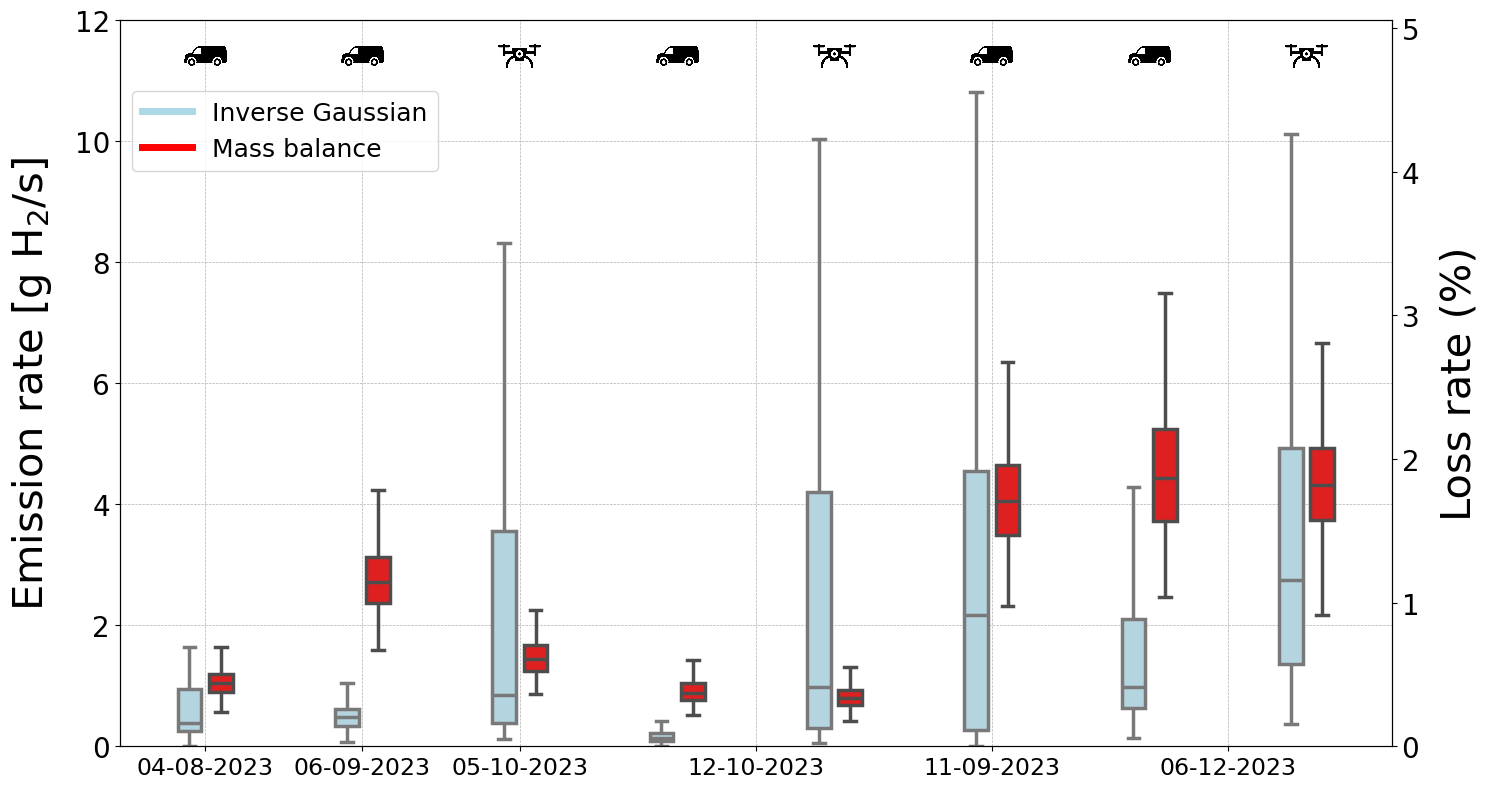

In [4]:
# Import libraries
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines
from io import StringIO
from scipy.stats import linregress
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import datetime as dt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', None)

# Load data
path = '/home/firmin.stroo/code/CH1_local/aether_python/output' # PATH WITH OUTPUT FILES HERE
save = False

file_gpm = 'a5_nofilter_n500.csv' # FILE WITH INVERSE GAUSSIAN RESULTS
file_mass_balance = 'c2_mass_balance_jackknife_iris_N500.csv' # FILE WITH MASS BALANCE RESULTS

# Preprocess Mass balance data
df_mass_balance = pd.read_csv(os.path.join(path, file_mass_balance))
df_mass_balance = df_mass_balance.rename(columns={'filename': 'measurement_id'})
df_mass_balance['measurement_id'] = df_mass_balance['measurement_id'].str.replace('.csv', '')

# Preprocess GPM data
df_gpm = pd.read_csv(os.path.join(path, file_gpm))

F4 = True
if F4:
    df_gpm = df_gpm[df_gpm['F4_Optimization_successful'] == True].copy().reset_index(drop=True)
else: # check if F1_Sufficient_data, F2_Optimization_not_null are all True
    df_gpm = df_gpm[(df_gpm['F1_Sufficient_data'] == True) & (df_gpm['F2_Optimization_not_null'] == True)].copy().reset_index(drop=True)
    df_gpm = df_gpm.groupby('measurement_id').sample(n=500, random_state=1).reset_index(drop=True)
    print(df_gpm.groupby('measurement_id').size().value_counts())

df_gpm['measurement_id'] = df_gpm['measurement_id'].str.replace('.csv', '') # remove .csv from measurement_id

#_______________________________________________________________________________________________________________________
subplot_ids = ['car_2023_08_04', 'car_2023_09_06', 'drone_2023_10_05', 'car_2023_10_12', 'drone_2023_10_12', 'car_2023_09_11', 'car_2023_12_06', 'drone_2023_12_06']

def plot_summary(monte_carlo_results, mass_balance_results, subplot_ids, show_fliers):
    car_image = mpimg.imread('/home/firmin.stroo/code/CH1_local/icons/logistic-van-icon.png')
    drone_image = mpimg.imread('/home/firmin.stroo/code/CH1_local/icons/camera-drone-icon.png')

    monte_carlo_results = monte_carlo_results.copy()
    mass_balance_results = mass_balance_results.copy()
    monte_carlo_results['Total emissions g/s'] = monte_carlo_results['Total emissions'] / 86400 * 1000  # Convert from kg/day to g/s
    mass_balance_results['Q_kg_day g/s'] = mass_balance_results['Q_kg_day'] / 86400 * 1000  # Convert from kg/day to g/s

    fig, ax = plt.subplots(figsize=(15, 8))
    vmax = max(6, 12)

    errorbar_added_to_legend = False  # Flag to check if error bars are added to legend
    park_daily_production = 20500  # kg/day
    park_daily_production_g_s = park_daily_production / 86400 * 1000 # Convert from kg/day to g/s
 
    def convert_to_date(measurement_id):
        year, month, day = measurement_id.split('_')[1:4]
        return dt.datetime(int(year), int(month), int(day))

    # Add GPM  results
    for i, measurement_id in enumerate(subplot_ids):
        monte_carlo_data = monte_carlo_results[monte_carlo_results['measurement_id'] == measurement_id]
        sns.boxplot(data=monte_carlo_data, x='measurement_id', y='Total emissions g/s', ax=ax, color='lightblue', linewidth=2.5, width=0.15, showfliers=show_fliers, positions=[i-0.1])
            
    # Loop over the mass balance results and add the mass balance estimates to the plot
    for i, measurement_id in enumerate(subplot_ids):
        mass_balance_data = mass_balance_results[mass_balance_results['measurement_id'] == measurement_id]
        sns.boxplot(data=mass_balance_data, x='measurement_id', y='Q_kg_day g/s', ax=ax, color='red', linewidth=2.5, width=0.15, positions=[i+0.1], showfliers=show_fliers)

        if 'car' in measurement_id:
            ab = AnnotationBbox(OffsetImage(car_image, zoom=0.06), (i, vmax*0.95), box_alignment=(0.5, 0.5), frameon=False)
            ax.add_artist(ab)
        elif 'drone' in measurement_id:
            ab = AnnotationBbox(OffsetImage(drone_image, zoom=0.06), (i, vmax*0.95), box_alignment=(0.5, 0.5), frameon=False)
            ax.add_artist(ab)

    ax.set_ylim(0, vmax)
    x_labels = [measurement_id.split('_')[3] + '-' + measurement_id.split('_')[2] + '-' + measurement_id.split('_')[1] for measurement_id in subplot_ids]
    ax2 = ax.twinx() # Create a second y-axis
    ax2.plot([], [])  # Create an empty plot to add the second y-axis label
    ax2.set_ylabel(r'Loss rate (%)', fontsize=30, labelpad=15)
    ax2.set_ylim([0, vmax / park_daily_production_g_s * 100]) # Set the limits of the second y-axis

    # Check for duplicate labels and adjust positions
    unique_labels = []
    label_positions = []
    for j, label in enumerate(x_labels):
        if j < len(x_labels) - 1 and label == x_labels[j + 1]:
            # If next label is the same, skip this one and plan to center the label between current and next
            continue
        unique_labels.append(label)
        # Position this label between current index j and the next, or directly at j if no next
        label_position = j if j == 0 or x_labels[j - 1] != label else (j + j - 1) / 2
        label_positions.append(label_position)

    ax.set_xticks(label_positions)
    ax.set_xticklabels(unique_labels)

    ax.set_xlabel('')
    ax.set_ylabel(r'Emission rate [g $\mathrm{H_2}$/s]', fontsize=30, labelpad=15)
    ax.tick_params(axis='both', labelsize=17)
    ax.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Organize legend items
    boxplot_proxy = mlines.Line2D([], [], color='lightblue', linewidth=5)
    mass_balance_proxy = mlines.Line2D([], [], color='red', linewidth=5)
    legend_handles = [boxplot_proxy, mass_balance_proxy]
    legend_labels = ['Inverse Gaussian', 'Mass balance']
    ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', bbox_to_anchor=(0, 0.92), fontsize=18)
    plt.tight_layout()
    if save == True:
        filename = file_gpm.split('.')[0] + '_summary.png'
        plt.savefig('/home/firmin.stroo/code/aether_python/output/figures/' + filename, dpi=300) # SAVE FIGURE HERE

    plt.show()

plot_summary(df_gpm, df_mass_balance, subplot_ids, show_fliers=False)